In [ ]:
import os
import json
import torch
import pickle
import numpy as np
from PIL import Image, ImageFilter 
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


In [6]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.7/769.7 kB 1.8 MB/s eta 0:00:0000:0100:01
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ijpuu202
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ijpuu202
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=a85bddd7576421df8d4a47f3fc8b23242e57635de767b5b996199985ebfe00c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-m6uyuun0/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


## Load the data from RefCOCOg

Here we load the annotation file with all the references and the images. 

In [4]:
with open("../extractCOCO/refcocog/annotations/refs(umd).p", "rb") as fp:
  annotations = pickle.load(fp)

  train_data = sorted([d for d in annotations if d["split"]=="train"], key=lambda d: d["file_name"])
  val_data = sorted([d for d in annotations if d["split"]=="val"], key=lambda d: d["image_id"])
  test_data = sorted([d for d in annotations if d["split"]=="test"], key=lambda d: d["image_id"])

  entry = train_data[0]

  print(json.dumps(entry, indent=4, default=str))



{
    "image_id": 9,
    "split": "train",
    "sentences": [
        {
            "tokens": [
                "a",
                "yellow",
                "rectangle",
                "bowl",
                "with",
                "broccoli",
                "and",
                "a",
                "brown",
                "food",
                "in",
                "it"
            ],
            "raw": "a yellow rectangle bowl with broccoli and a brown food in it",
            "sent_id": 92713,
            "sent": "a yellow rectangle bowl with broccoli and a brown food in it"
        },
        {
            "tokens": [
                "the",
                "tray",
                "that",
                "holds",
                "the",
                "broccoli"
            ],
            "raw": "The tray that holds the broccoli.",
            "sent_id": 92714,
            "sent": "the tray that holds the broccoli"
        }
    ],
    "file_name": "COCO_train2014_00000000

Here the data loader class.

In [2]:
import os
import json

from torch.utils.data import Dataset

class RefCOCOg(Dataset):
    def __init__(self, refs, annotations, split="train"):

        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": elem["sentences"][0]["raw"],
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]
    
    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))

In [3]:
# Load refs and annotations
import pickle

with open("../extractCOCO/refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

with open("../extractCOCO/refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

In [4]:
# load the train dataset
train_dataset = RefCOCOg(refs=refs, annotations=annotations, split="train")

print(train_dataset[0])
print(train_dataset)
print(len(train_dataset))
train_dataset(0)

{'file_name': './refcocog/images/COCO_train2014_000000519404.jpg', 'caption': 'Two woman one in black eatting and the other has a white shirt at the desk', 'ann_id': 1241542, 'bbox': [0.0, 45.95, 238.92, 408.64]}
42226
{
    "file_name": "./refcocog/images/COCO_train2014_000000519404.jpg",
    "caption": "Two woman one in black eatting and the other has a white shirt at the desk",
    "ann_id": 1241542,
    "bbox": [
        0.0,
        45.95,
        238.92,
        408.64
    ]
}


### BLUR the images

Here I have done some experiments in blurring the images in/out the bounding box. I would like to see if removing the context inside the bounding box the score it remains hight. Weather we remove the object described in the target caption, the score should be lower. On the other hand, if we blur outside the bounding box and the object described in the target caption isn't visible, the score should be lower. In this way we can see if the model is using the context inside the bounding box is able to retrive if it is the object described in the target caption.

In [11]:
import clip
import torch

# https://github.com/baaivision/EVA/tree/master/EVA-CLIP
# https://huggingface.co/QuanSun/EVA-CLIP

device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load("RN50", device=device)
x_min, y_min, x_max, y_max = train_dataset[0]["bbox"]


img = Image.open('../extractCOCO/'+train_dataset[0]["file_name"][1:])


mask = np.zeros_like(np.array(img))
mask[int(y_min):int(y_max),int(x_min):int(x_max)] = np.array(img)[int(y_min):int(y_max),int(x_min):int(x_max)]
remove_box = np.array(img)-mask
im = np.array((img).filter(ImageFilter.GaussianBlur(radius = 30)))
remove_box[int(y_min):int(y_max),int(x_min):int(x_max)] = remove_box[int(y_min):int(y_max),int(x_min):int(x_max)] + np.array(im)[int(y_min):int(y_max),int(x_min):int(x_max)]


im = np.array((img).filter(ImageFilter.GaussianBlur(radius = 30)))
mask = np.zeros_like(np.array(im))
mask[int(y_min):int(y_max),int(x_min):int(x_max)] = np.array(img)[int(y_min):int(y_max),int(x_min):int(x_max)]
im[int(y_min):int(y_max),int(x_min):int(x_max)] = im[int(y_min):int(y_max),int(x_min):int(x_max)]-im[int(y_min):int(y_max),int(x_min):int(x_max)]
im[int(y_min):int(y_max),int(x_min):int(x_max)] = im[int(y_min):int(y_max),int(x_min):int(x_max)] + mask[int(y_min):int(y_max),int(x_min):int(x_max)]

mask = np.zeros_like(np.array(im))
mask[int(y_min):int(y_max),int(x_min):int(x_max)] = np.array(img)[int(y_min):int(y_max),int(x_min):int(x_max)]


image = torch.stack([preprocess(i).unsqueeze(0) for i in [Image.fromarray(remove_box), Image.fromarray(im),Image.fromarray(np.array(img)-mask),img]]).squeeze(1).to(device)
text = clip.tokenize([train_dataset[0]["caption"]]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_text.softmax(dim=-1).cpu().numpy().round(3)

print("Label probs:", probs)


Label probs: [[0.003 0.868 0.002 0.127]]


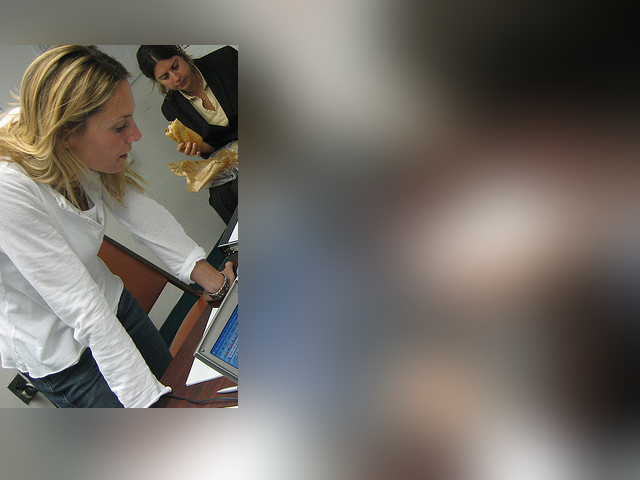

In [7]:
Image.fromarray(im) 
# the image with the higher score is the one
# which has exactly the bounding box centered
# in the right way

Two woman one in black eatting and the other has a white shirt at the desk


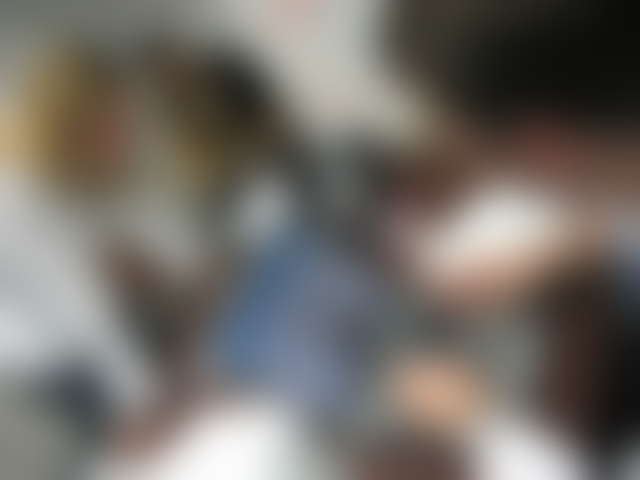

In [26]:
print(train_dataset[0]["caption"])

im

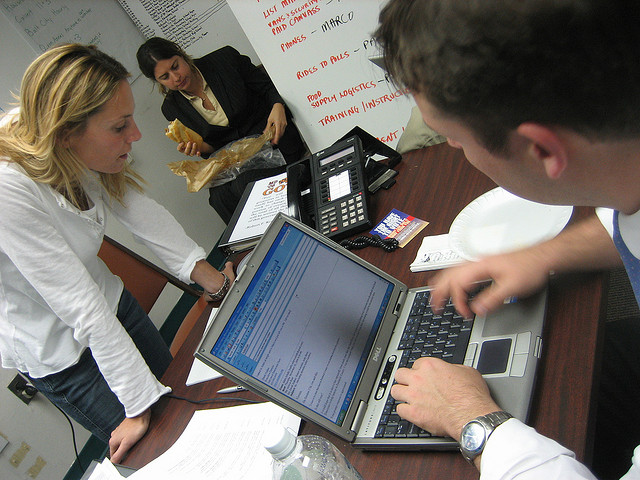

In [35]:
Image.open('../extractCOCO/'+train_dataset[0]["file_name"][1:])

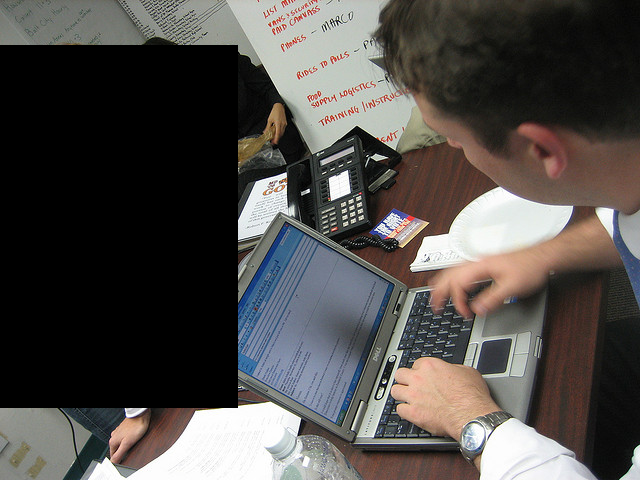

In [59]:
Image.fromarray(np.array(img)-mask)

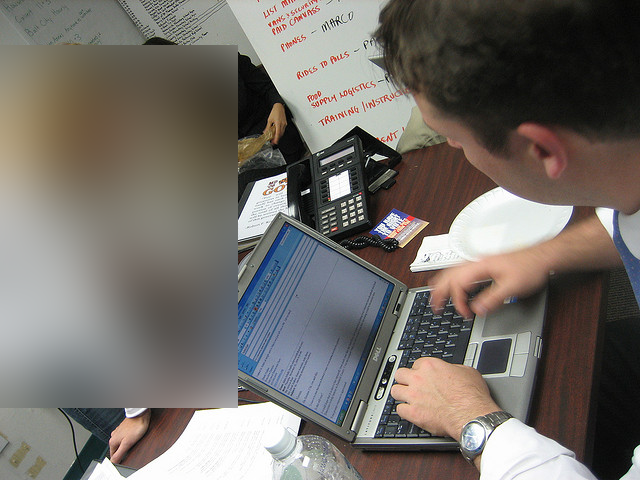

In [79]:
remove_box = np.array(img)-mask

im = np.array(Image.open('../extractCOCO/'+train_dataset[0]["file_name"][1:]).filter(ImageFilter.GaussianBlur(radius = 30)))

remove_box[int(y_min):int(y_max),int(x_min):int(x_max)] = remove_box[int(y_min):int(y_max),int(x_min):int(x_max)] + np.array(im)[int(y_min):int(y_max),int(x_min):int(x_max)]

Image.fromarray(remove_box)

In [64]:
import clip
import torch

# https://github.com/baaivision/EVA/tree/master/EVA-CLIP
# https://huggingface.co/QuanSun/EVA-CLIP

device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load("RN50", device=device)



sample = train_dataset[400]
print(sample["caption"])
print(sample["file_name"])
print(sample["bbox"])

x_min, y_min, x_max, y_max = sample["bbox"]

# extract the image
img = Image.open('../extractCOCO/'+sample["file_name"][1:])

# blur the image
im = np.array((img).filter(ImageFilter.GaussianBlur(radius = 30)))

# create the mask
mask = np.zeros_like(np.array(im))

# get blur image out of the bounding box
y_1, y_2 = int(y_min), int(y_min)+int(y_max)
x_1, x_2 = int(x_min), int(x_min)+int(x_max)


mask[y_1:y_2,x_1:x_2] = np.array(img)[y_1:y_2,x_1:x_2]
im[y_1:y_2,x_1:x_2] = im[y_1:y_2,x_1:x_2]-im[y_1:y_2,x_1:x_2]
im[y_1:y_2,x_1:x_2] = im[y_1:y_2,x_1:x_2] + mask[y_1:y_2,x_1:x_2]


# here with the mask we remove the bounding box

remove_box = np.array(img)-mask
i = np.array((img).filter(ImageFilter.GaussianBlur(radius = 30)))
remove_box[y_1:y_2,x_1:x_2] = remove_box[y_1:y_2,x_1:x_2] + np.array(i)[y_1:y_2,x_1:x_2]


image = torch.stack([preprocess(i).unsqueeze(0) for i in [Image.fromarray(remove_box), Image.fromarray(im),img]]).squeeze(1).to(device)
text = clip.tokenize([train_dataset[0]["caption"]]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_text.softmax(dim=-1).cpu().numpy().round(3)

print("Label probs:", probs)


A suitcase sitting on the bed.
./refcocog/images/COCO_train2014_000000515401.jpg
[447.57, 136.76, 190.27, 337.29]
Label probs: [[0.168 0.819 0.013]]


A suitcase sitting on the bed.


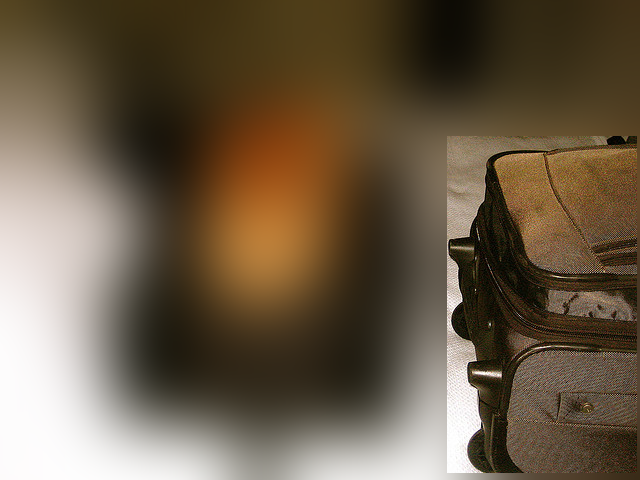

In [66]:
print(sample["caption"])
Image.fromarray(im) # show the image with the higher score

### Problematic samples

In this specific sample as we can see we have two suitecase on the bed. Here the sample is ambiguous. Due to that we can not pretend on this dataset to have a 100% accuracy.

A suitcase sitting on the bed.
./refcocog/images/COCO_train2014_000000515401.jpg
[447.57, 136.76, 190.27, 337.29]


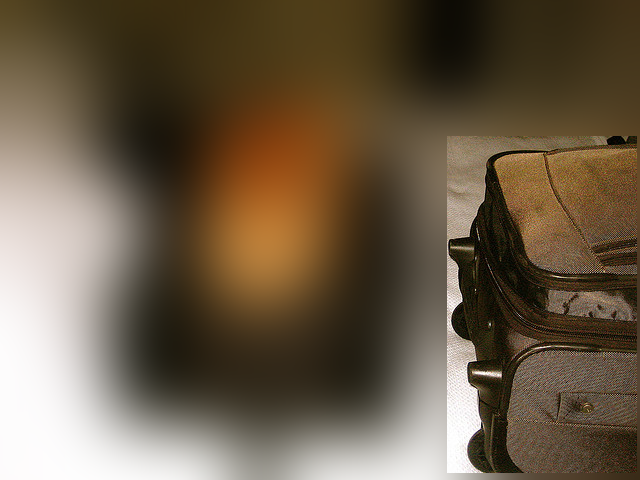

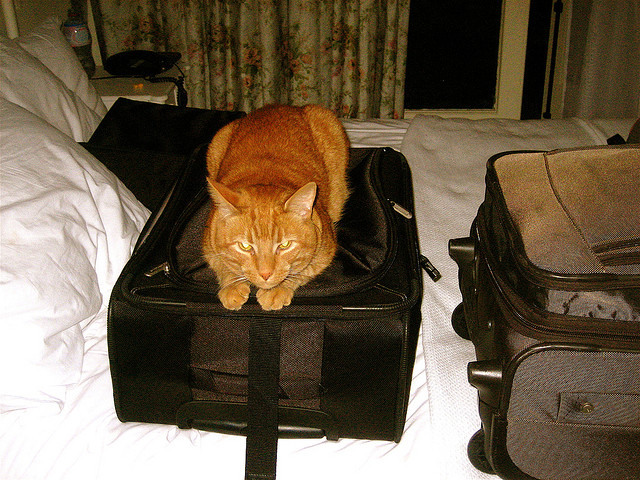

In [56]:
sample = train_dataset[400]
print(sample["caption"])
print(sample["file_name"])
print(sample["bbox"])

x_min, y_min, x_max, y_max = sample["bbox"]

# extract the image
img = Image.open('../extractCOCO/'+sample["file_name"][1:])

# blur the image
im = np.array((img).filter(ImageFilter.GaussianBlur(radius = 30)))

# create the mask
mask = np.zeros_like(np.array(im))

# get blur image out of the bounding box
y_1, y_2 = int(y_min), int(y_min)+int(y_max)
x_1, x_2 = int(x_min), int(x_min)+int(x_max)


mask[y_1:y_2,x_1:x_2] = np.array(img)[y_1:y_2,x_1:x_2]
im[y_1:y_2,x_1:x_2] = im[y_1:y_2,x_1:x_2]-im[y_1:y_2,x_1:x_2]
im[y_1:y_2,x_1:x_2] = im[y_1:y_2,x_1:x_2] + mask[y_1:y_2,x_1:x_2]

# get image
Image.fromarray(im).show()
img.show()

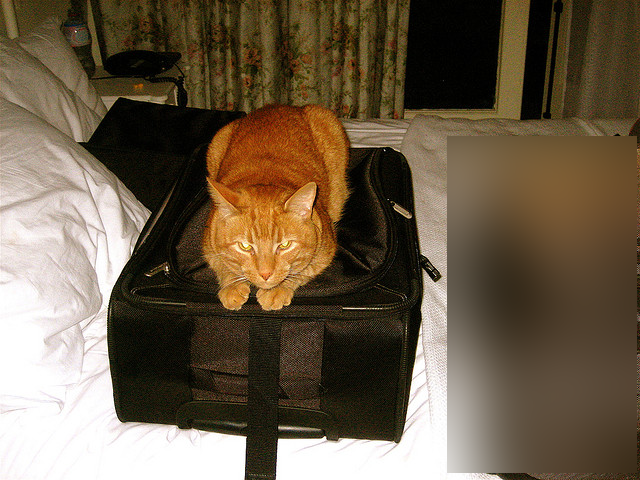

In [60]:
# here with the mask we remove the bounding box

remove_box = np.array(img)-mask

im = np.array((img).filter(ImageFilter.GaussianBlur(radius = 30)))

remove_box[y_1:y_2,x_1:x_2] = remove_box[y_1:y_2,x_1:x_2] + np.array(im)[y_1:y_2,x_1:x_2]

Image.fromarray(remove_box)

Functions wich perform the blurring.

The carrots toward the front of the picture.
./refcocog/images/COCO_train2014_000000564050.jpg
[142.39, 239.66, 262.82, 169.65]


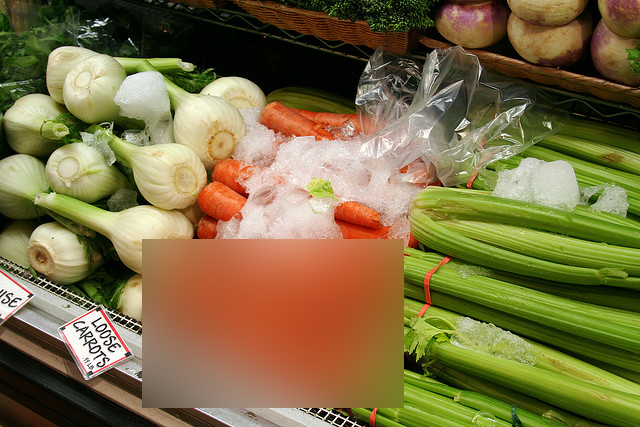

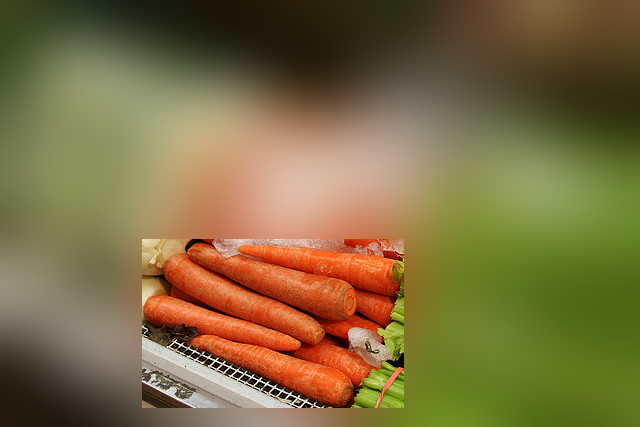

In [9]:
def blur_out(image, box):
    """ Blur the image out of the bounding box
    
    """
    x_min, y_min, x_max, y_max = box

    # blur the image
    im = np.array((image).filter(ImageFilter.GaussianBlur(radius = 30)))

    # create the mask
    mask = np.zeros_like(np.array(im))

    # get blur image out of the bounding box
    y_1, y_2 = int(y_min), int(y_min)+int(y_max)
    x_1, x_2 = int(x_min), int(x_min)+int(x_max)

    # blur the image
    mask[y_1:y_2,x_1:x_2] = np.array(image)[y_1:y_2,x_1:x_2]
    im[y_1:y_2,x_1:x_2] = im[y_1:y_2,x_1:x_2]-im[y_1:y_2,x_1:x_2]
    im[y_1:y_2,x_1:x_2] = im[y_1:y_2,x_1:x_2] + mask[y_1:y_2,x_1:x_2]

    # return the image blurred
    return Image.fromarray(im)


def blur_in(image, box):
    """ Blur the image in the bounding box
    
    """
    x_min, y_min, x_max, y_max = box

    # blur the image
    im = np.array((image).filter(ImageFilter.GaussianBlur(radius = 30)))

    # create the mask
    mask = np.zeros_like(np.array(im))

    # get blur image out of the bounding box
    y_1, y_2 = int(y_min), int(y_min)+int(y_max)
    x_1, x_2 = int(x_min), int(x_min)+int(x_max)

    # blur the image
    mask[y_1:y_2,x_1:x_2] = np.array(image)[y_1:y_2,x_1:x_2]

    # blur the image in the box
    remove_box = np.array(image)-mask
    im = np.array((image).filter(ImageFilter.GaussianBlur(radius = 30)))
    remove_box[y_1:y_2,x_1:x_2] = remove_box[y_1:y_2,x_1:x_2] + np.array(im)[y_1:y_2,x_1:x_2]

    return Image.fromarray(remove_box)

sample = train_dataset[500]
print(sample["caption"])
print(sample["file_name"])
print(sample["bbox"])

# extract the image
img = Image.open('../extractCOCO/'+sample["file_name"][1:])
blur_in(img, sample["bbox"]).show()
blur_out(img, sample["bbox"]).show()
